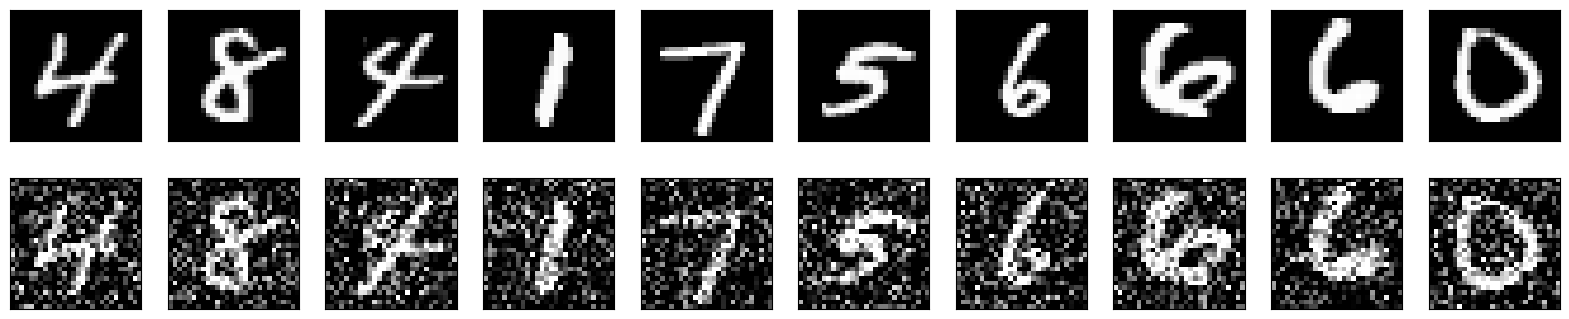

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras.datasets import mnist
from keras.models import Model


def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

In [2]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (5, 5), activation='relu')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (5, 5), activation='relu')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8)

x = layers.UpSampling2D((2,2))(encoded)
x = layers.Conv2DTranspose(8, (5, 5), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2DTranspose(1, (5, 5), activation='sigmoid')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

2024-12-25 15:37:56.812170: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-25 15:37:56.815920: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 24, 24, 16)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 8)           3208      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 8)          0         
 2D)                                                             
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 8)          0     

In [4]:
history=autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=1,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data))

469/469 [==============================] - 31s 66ms/step - loss: 0.2207 - val_loss: 0.1340


In [5]:
history.history['loss']

[0.22069130837917328]

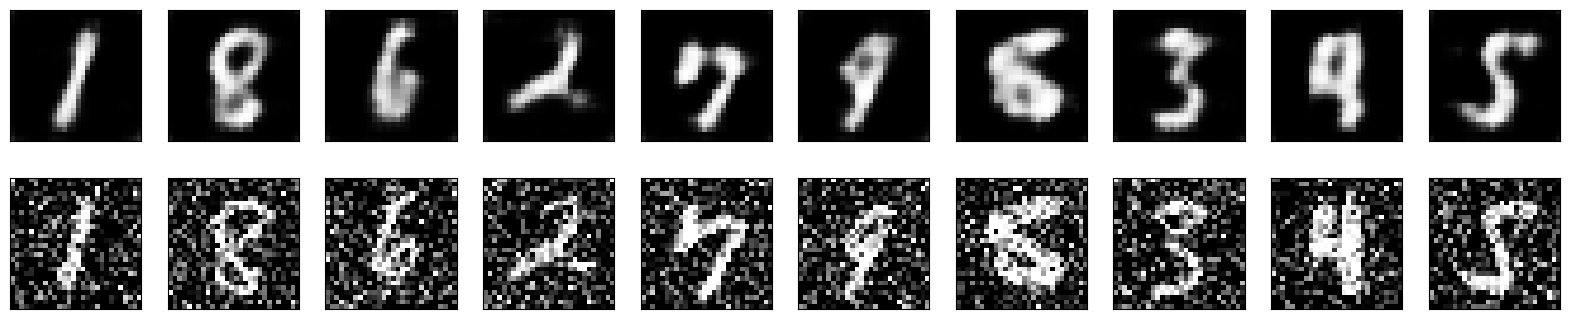

In [6]:
prediction=autoencoder.predict(noisy_test_data)
display(prediction,noisy_test_data)